<a href="https://colab.research.google.com/github/castorhyun/DeepLearningZeroToAll/blob/master/fund_prediction_MLP_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/0011.데이터모델링/Data_2017

/content/gdrive/My Drive/Colab Notebooks/0011.데이터모델링/Data_2017


라이브러리 import


In [3]:
import pandas as pd


In [4]:
# 학습대상 데이터 Load
data_in = pd.read_csv("cvt_201701.csv")
data_in = pd.concat([data_in, pd.read_csv("cvt_201702.csv")], ignore_index=True)
data_in = pd.concat([data_in, pd.read_csv("cvt_201703.csv")], ignore_index=True)
data_in = pd.concat([data_in, pd.read_csv("cvt_201704.csv")], ignore_index=True)

거래금액 기준 75% 데이터로 축소 ( 거액거래건은 제외 - 법인거래관련 )

In [5]:
data_in = data_in[data_in['resv_amt'] < 3.000000e+05 ]

In [6]:
data_in[data_in['cnt'] > 0].describe()

,sno,age,postno,sincdt,early_cnt,mid_cnt,late_cnt,resv_amt,cnt,A0_cnt,C0_cnt,CK_cnt,D0_cnt,DT_cnt,G0_cnt,jibul_psb_jan,jan,bfmm_ac_jan,m_avjn,bfmm_ac_avjn,lm3_ac_avjn,lm6_ac_avjn,lm12_ac_avjn,jibul_psb_jan_1,jan_1,bfmm_ac_jan_1,m_avjn_1,bfmm_ac_avjn_1,lm3_ac_avjn_1,lm6_ac_avjn_1,lm12_ac_avjn_1
count,79590.000000,79590.000000,79590.000000,7.959000e+04,79590.000000,79590.0,79590.0,79590.000000,79590.000000,79590.000000,79590.000000,79590.000000,79590.000000,79590.000000,79590.000000,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04,7.959000e+04
mean,4982.938874,40.428898,20531.722742,2.017027e+07,1.057532,0.0,0.0,94671.219299,1.057532,0.288830,0.034703,0.000075,0.122993,0.609788,0.001143,-2.571666e+04,3.921352e+06,3.676365e+06,3.834619e+06,3.354078e+06,3.461713e+06,3.192273e+06,2.938545e+06,-2.915516e+04,3.894934e+06,3.651461e+06,3.807930e+06,3.331584e+06,3.438088e+06,3.173772e+06,2.927878e+06
std,2878.522471,12.885457,23710.514020,1.078082e+02,0.401400,0.0,0.0,60683.417372,0.401400,0.456949,0.197363,0.008682,0.406184,0.609785,0.034164,4.808150e+06,1.403401e+07,1.465386e+07,1.131697e+07,1.330633e+07,1.208067e+07,1.052432e+07,8.479121e+06,4.837397e+06,1.401285e+07,1.463142e+07,1.128883e+07,1.328778e+07,1.206090e+07,1.052425e+07,8.502025e+06
min,1.000000,0.000000,0.000000,2.017010e+07,1.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.887231e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.887231e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2488.000000,31.000000,7065.000000,2.017021e+07,1.000000,0.0,0.0,49500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.309475e+04,1.062650e+04,1.622002e+05,7.972000e+04,1.750948e+05,1.781100e+05,1.892415e+05,0.000000e+00,3.681700e+04,8.691000e+03,1.479560e+05,6.957450e+04,1.601238e+05,1.661125e+05,1.783090e+05
50%,4968.000000,40.000000,14543.000000,2.017031e+07,1.000000,0.0,0.0,100000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.551640e+05,4.821270e+05,8.550335e+05,6.260925e+05,8.346425e+05,8.085405e+05,7.963185e+05,0.000000e+00,6.345660e+05,4.550230e+05,8.366155e+05,6.090590e+05,8.145625e+05,7.935560e+05,7.804990e+05
75%,7454.000000,49.000000,28403.000000,2.017033e+07,1.000000,0.0,0.0,100000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,3.022105e+06,2.579874e+06,3.173725e+06,2.409728e+06,2.864028e+06,2.645294e+06,2.556414e+06,0.000000e+00,3.001719e+06,2.543138e+06,3.149016e+06,2.381371e+06,2.837709e+06,2.630734e+06,2.543120e+06
max,9999.000000,94.000000,791080.000000,2.017043e+07,20.000000,0.0,0.0,298901.000000,20.000000,4.000000,5.000000,1.000000,18.000000,20.000000,2.000000,6.703064e+08,1.187801e+09,1.038853e+09,5.586150e+08,1.129549e+09,1.011125e+09,8.248434e+08,4.091168e+08,6.703064e+08,1.187801e+09,1.038853e+09,5.586150e+08,1.129549e+09,1.011125e+09,8.248434e+08,4.091168e+08


In [ ]:
data_in[data_in['cnt'] > 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110863 entries, 18 to 1526610
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sno              110863 non-null  int64 
 1   age              110863 non-null  int64 
 2   postno           110863 non-null  int64 
 3   trxMM            110863 non-null  object
 4   sincdt           110863 non-null  int64 
 5   early_cnt        110863 non-null  int64 
 6   mid_cnt          110863 non-null  int64 
 7   late_cnt         110863 non-null  int64 
 8   resv_amt         110863 non-null  int64 
 9   cnt              110863 non-null  int64 
 10  A0_cnt           110863 non-null  int64 
 11  C0_cnt           110863 non-null  int64 
 12  CK_cnt           110863 non-null  int64 
 13  D0_cnt           110863 non-null  int64 
 14  DT_cnt           110863 non-null  int64 
 15  G0_cnt           110863 non-null  int64 
 16  jibul_psb_jan    110863 non-null  int64 
 17  jan     

In [7]:
from tqdm import tqdm

# 채널별 거래건수를 통해 입금여부 Label 로 설정
# 각 거래채널별 거래건수를 합산 - 거래가 있는 경우 1 , 없으면 0
trx_cnt = list(data_in['A0_cnt'] + data_in['C0_cnt'] + data_in['CK_cnt'] + data_in['D0_cnt'] + data_in['DT_cnt'] + data_in['G0_cnt'])

ip_yn = []

for i in tqdm(range(len(trx_cnt))):
  if trx_cnt[i] > 0:
    ip_yn.append(1)
  else:
    ip_yn.append(0)


data_in['ip_yn'] = ip_yn

100%|██████████| 1495351/1495351 [00:00<00:00, 2439840.58it/s]


In [8]:
trx_df = data_in[data_in['ip_yn'] == 1]
notrx_df = data_in[data_in['ip_yn'] == 0]


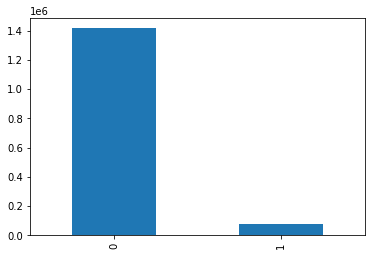

In [9]:
# 데이터 라벨 분포 확인해보기
data_in['ip_yn'].value_counts().plot(kind='bar')

In [10]:
data_in['ip_yn'].value_counts()

0    1415761
1      79590
Name: ip_yn, dtype: int64

In [11]:
# 학습데이터 비율 조정
# 입금거래데이터 79,590
# 비입금데이터 1,415,761

filt_notrx_df = notrx_df.iloc[0:79590]

new_train_data = pd.concat([trx_df, filt_notrx_df])
new_train_data = new_train_data.sort_values(by=['sno'], axis=0, ascending=True)


In [13]:
trx_df.head(1)

,sno,age,postno,trxMM,sincdt,early_cnt,mid_cnt,late_cnt,resv_amt,cnt,A0_cnt,C0_cnt,CK_cnt,D0_cnt,DT_cnt,G0_cnt,jibul_psb_jan,jan,bfmm_ac_jan,m_avjn,bfmm_ac_avjn,lm3_ac_avjn,lm6_ac_avjn,lm12_ac_avjn,jibul_psb_jan_1,jan_1,bfmm_ac_jan_1,m_avjn_1,bfmm_ac_avjn_1,lm3_ac_avjn_1,lm6_ac_avjn_1,lm12_ac_avjn_1,ip_yn
18,3925,27,5118,201701,20170118,1,0,0,50000,1,0,0,0,0,1,0,0,42294,81532,99841,125701,129017,123529,100314,0,42294,81532,99841,125701,129017,123529,100314,1


In [36]:
# 학습데이터 만들기 ver.2
# 입금데이터 건수 줄이기

x_train = pd.DataFrame()
y_train = pd.DataFrame()

x_train['sno'] = new_train_data['sno']
x_train['age'] = new_train_data['age']
x_train['postno'] = new_train_data['postno']


x_train['jibul_psb_jan_1'] = new_train_data['jibul_psb_jan_1']
x_train['jan_1'] = new_train_data['jan_1']
x_train['bfmm_ac_jan_1'] = new_train_data['bfmm_ac_jan_1']
x_train['m_avjn_1'] = new_train_data['m_avjn']
x_train['bfmm_ac_avjn_1'] = new_train_data['bfmm_ac_avjn_1']
x_train['lm3_ac_avjn_1'] = new_train_data['lm3_ac_avjn_1']
x_train['lm6_ac_avjn_1'] = new_train_data['lm6_ac_avjn_1']
x_train['lm12_ac_avjn_1'] = new_train_data['lm12_ac_avjn_1']

y_train = new_train_data['ip_yn']

In [37]:
y_train.value_counts()

1    79590
0    79590
Name: ip_yn, dtype: int64

In [38]:
x_train

,sno,age,postno,jibul_psb_jan_1,jan_1,bfmm_ac_jan_1,m_avjn_1,bfmm_ac_avjn_1,lm3_ac_avjn_1,lm6_ac_avjn_1,lm12_ac_avjn_1
63879,0,76,3743,0,0,0,0,0,0,0,0
42085,0,53,3941,117630,0,0,0,0,0,75333,37872
75033,0,38,63327,0,19921300,20306814,0,21808179,21498804,20381458,11550240
5868,0,65,21357,0,1932493,1940983,0,1406293,1418835,918979,945847
55531,0,53,3941,117630,0,0,0,0,0,75333,37872
...,...,...,...,...,...,...,...,...,...,...,...
218678,9999,10,6514,0,100345,200318,119676,109983,111177,73669,39287
10307,9999,24,7524,0,400069,176096,0,586626,603465,557097,896967
77122,9999,65,4790,984695,12203977,12527292,0,13448194,13652813,13520220,12496505
741749,9999,51,18440,0,6267341,0,302407,0,94082,46781,23198


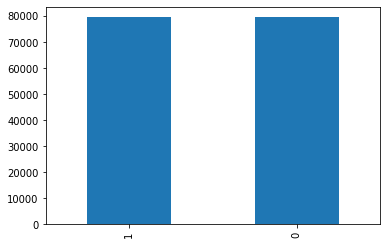

In [19]:
# 데이터 라벨 분포 확인해보기
new_train_data['ip_yn'].value_counts().plot(kind='bar')

In [39]:
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

모델 학습하기


In [22]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
import random

from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 


Using TensorFlow backend.


In [23]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [41]:

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(20, input_dim=11, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train_np, y_train_np, epochs=10, batch_size=64,validation_split=0.2)

Train on 127344 samples, validate on 31836 samples
Epoch 1/10
127344/127344 [==============================] - 3s 21us/step - loss: 0.4188 - accuracy: 0.8183 - precision: 0.8555 - recall: 0.8090 - f1score: 0.8213 - val_loss: 0.3039 - val_accuracy: 0.8659 - val_precision: 0.9006 - val_recall: 0.8239 - val_f1score: 0.8563
Epoch 2/10
127344/127344 [==============================] - 3s 21us/step - loss: 0.2708 - accuracy: 0.8815 - precision: 0.8953 - recall: 0.8642 - f1score: 0.8777 - val_loss: 0.2703 - val_accuracy: 0.8924 - val_precision: 0.9379 - val_recall: 0.8404 - val_f1score: 0.8824
Epoch 3/10
127344/127344 [==============================] - 3s 21us/step - loss: 0.2456 - accuracy: 0.8970 - precision: 0.9249 - recall: 0.8645 - f1score: 0.8920 - val_loss: 0.2553 - val_accuracy: 0.8905 - val_precision: 0.9144 - val_recall: 0.8631 - val_f1score: 0.8842
Epoch 4/10
127344/127344 [==============================] - 3s 21us/step - loss: 0.2347 - accuracy: 0.8949 - precision: 0.9138 - recall:

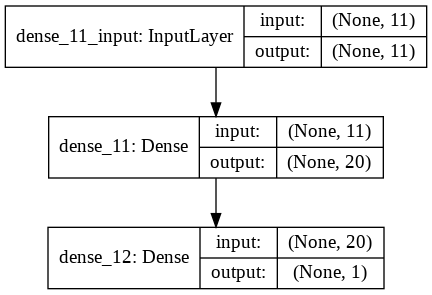

In [42]:
from keras.utils import plot_model

plot_model(model, to_file='./model_fund_MLP.png', show_layer_names=True, show_shapes=True)

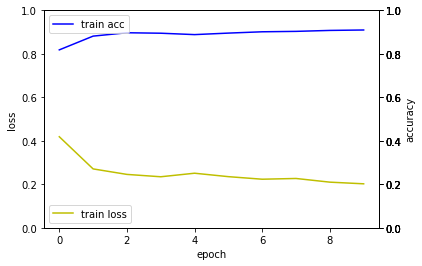

In [43]:
# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()
prec_ax = loss_ax.twinx()
recall_ax = loss_ax.twinx()
f1_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

prec_ax.set_ylim([0.0, 1.0])
recall_ax.set_ylim([0.0, 1.0])
f1_ax.set_ylim([0.0, 1.0])


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

#prec_ax.plot(hist.history['precision'], 'p', label='train precision')
#recall_ax.plot(hist.history['recall'], 'r', label='train recall')
#f1_ax.plot(hist.history['f1score'], 'g', label='train f1score')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

#prec_ax.set_ylabel('precision')
#recall_ax.set_ylabel('recall')
#f1_ax.set_ylabel('f1score')

loss_ax.legend(loc='lower left')
acc_ax.legend(loc='upper left')

#prec_ax.legend(loc='upper left')
#recall_ax.legend(loc='upper left')
#f1_ax.legend(loc='upper left')


plt.show()

In [44]:
# 평가데이터 만들기

data_eval = pd.read_csv('cvt_201709.csv')
data_eval = pd.concat([data_eval, pd.read_csv("cvt_201710.csv")], ignore_index=True)
data_eval = pd.concat([data_eval, pd.read_csv("cvt_201711.csv")], ignore_index=True)
data_eval = pd.concat([data_eval, pd.read_csv("cvt_201712.csv")], ignore_index=True)

from tqdm import tqdm

# 각 거래채널별 거래건수를 합산 - 거래가 있는 경우 1 , 없으면 0
trx_cnt = list(data_eval['A0_cnt'] + data_eval['C0_cnt'] + data_eval['CK_cnt'] + data_eval['D0_cnt'] + data_eval['DT_cnt'] + data_eval['G0_cnt'])

ip_yn = []

for i in tqdm(range(len(trx_cnt))):
  if trx_cnt[i] > 0:
    ip_yn.append(1)
  else:
    ip_yn.append(0)


data_eval['ip_yn'] = ip_yn



100%|██████████| 1526624/1526624 [00:00<00:00, 2412047.55it/s]


In [47]:
# 평가데이터 만들기 - 비율조정

eval_trx_df = data_eval[data_eval['ip_yn'] == 1]
eval_notrx_df = data_eval[data_eval['ip_yn'] == 0]

new_eval_data = pd.concat([eval_trx_df, eval_notrx_df])


x_test = pd.DataFrame()
y_test = pd.DataFrame()


x_test['sno'] = new_eval_data['sno']
x_test['age'] = new_eval_data['age']
x_test['postno'] = new_eval_data['postno']

x_test['jibul_psb_jan_1'] = new_eval_data['jibul_psb_jan_1']
x_test['jan_1'] = new_eval_data['jan_1']
x_test['bfmm_ac_jan_1'] = new_eval_data['bfmm_ac_jan_1']
x_test['m_avjn_1'] = new_eval_data['m_avjn']
x_test['bfmm_ac_avjn_1'] = new_eval_data['bfmm_ac_avjn_1']
x_test['lm3_ac_avjn_1'] = new_eval_data['lm3_ac_avjn_1']
x_test['lm6_ac_avjn_1'] = new_eval_data['lm6_ac_avjn_1']
x_test['lm12_ac_avjn_1'] = new_eval_data['lm12_ac_avjn_1']

y_test = new_eval_data['ip_yn']


x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()


In [48]:
# 학습모델 평가하기

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test_np, y_test_np, batch_size=64)
print('loss_and_metrics : ' + str(loss_and_metrics))



1526624/1526624 [==============================] - 16s 10us/step
loss_and_metrics : [0.18337343386904525, 0.9196409583091736, 0.16157877445220947, 0.14286454021930695, 0.15155211091041565]
